In [2]:

import numpy as np
import pandas as pd

from google.colab import files
#upload = files.upload()

#You can download the dataset:  
#https://www.kaggle.com/tmdb/tmdb-movie-metadata/downloads/tmdb-5000-movie-dataset.zip/2
credit = pd.read_csv("tmdb_5000_credits.csv")

movie_incomplete = pd.read_csv("tmdb_5000_movies.csv")

print("Credit:", credit.shape)
print("Movie_incomplete:", movie_incomplete.shape)

Credit: (4803, 4)
Movie_incomplete: (4803, 20)


In [3]:
credit.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [4]:
# Credit to Ibtesam Ahmed for her kernel:
# https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system


credits_renamed = credit.rename(index = str, columns={"movie_id":"id"})
movies_dirty = movie_incomplete.merge(credits_renamed, on="id")
movies_dirty.head()
                                     

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
movies_clean = movies_dirty.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
movies_clean.head()




,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


#Basic Recommender Systems

##The formula IMDB
![alt text](https://cdn-images-1.medium.com/max/800/1*fGziZl2Do-VyQXSCPq_Y2Q.png)

In [0]:
#we’ll use the formula IMDB (formerly) used to calculate weighted ratings for movies
#http://trailerpark.weebly.com/imdb-rating.html

V = movies_clean['vote_count']
R = movies_clean['vote_average']
C = movies_clean['vote_average'].mean()
# We will use 90th percentile as our cutoff. In other words, for a movie to feature 
#in the charts, it must have more votes than at least 90% of the movies in the list.
m = movies_clean['vote_count'].quantile(0.90)


movies_clean['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)

In [7]:
movies_ranked = movies_clean.sort_values('weighted_average', ascending=False)
movies_ranked[['original_title', 'vote_count', 'vote_average', 'weighted_average', 'popularity']].head(20)



,original_title,vote_count,vote_average,weighted_average,popularity
1881,The Shawshank Redemption,8205,8.5,8.059258,136.747729
662,Fight Club,9413,8.3,7.939256,146.757391
65,The Dark Knight,12002,8.2,7.920020,187.322927
3232,Pulp Fiction,8428,8.3,7.904645,121.463076
96,Inception,13752,8.1,7.863239,167.583710
3337,The Godfather,5893,8.4,7.851236,143.659698
95,Interstellar,10867,8.1,7.809479,724.247784
809,Forrest Gump,7927,8.2,7.803188,138.133331
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243,123.630332
1990,The Empire Strikes Back,5879,8.2,7.697884,78.517830


### Recommend ten movies with the highest weighted average ratings

Text(0, 0.5, 'Movie Title')

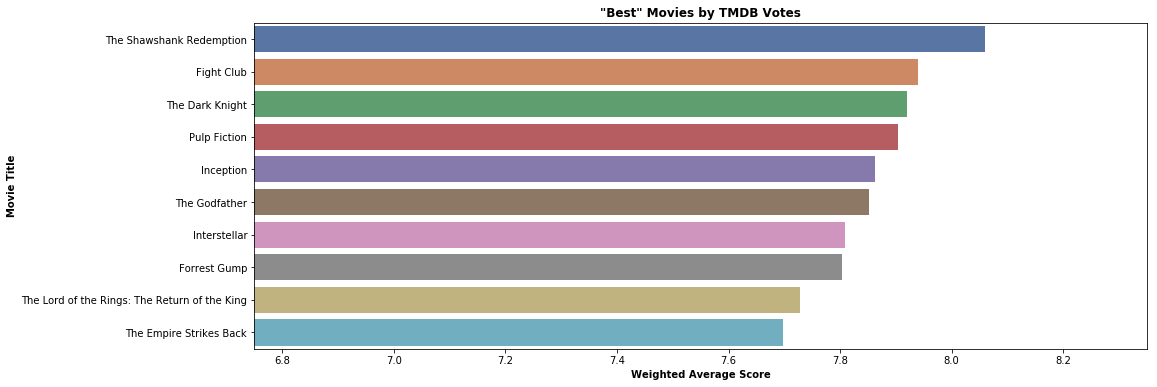

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

wavg = movies_ranked.sort_values('weighted_average', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=wavg['weighted_average'].head(10), y=wavg['original_title'].head(10), data=wavg, palette='deep')

plt.xlim(6.75, 8.35)
plt.title('"Best" Movies by TMDB Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')


### Recommend ten movies with the highest  ratings

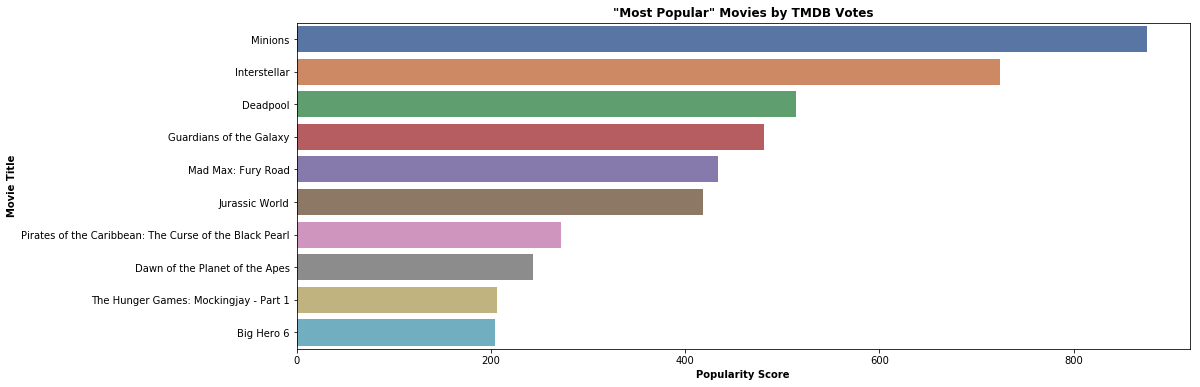

In [9]:
popular = movies_ranked.sort_values("popularity", ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=popular["popularity"].head(10),y=popular["original_title"].head(10),data=popular, palette='deep')

plt.title('"Most Popular" Movies by TMDB Votes', weight='bold')
plt.xlabel('Popularity Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')


plt.savefig('popular_movies.png')

####In order to avoid the colossal popularity score of Minions skewing our new scoring system, I normalized the values in both the weighted_average and popularity columns. I decided to go with a 50/50 split between the scaled weighted average rating and popularity scores, you can have another way to split.

In [10]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
movies_scaled = min_max_scaler.fit_transform(movies_clean[['weighted_average', 'popularity']]) 
movies_norm = pd.DataFrame(movies_scaled,columns=['weighted_average', 'popularity'])
movies_norm.head()

,weighted_average,popularity
0,0.652633,0.171815
1,0.520045,0.158846
2,0.373224,0.122635
3,0.754596,0.128272
4,0.323964,0.050169


In [11]:
movies_clean[['norm_weighted_average', 'norm_popularity']] = movies_norm
movies_clean.head(4)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew,weighted_average,norm_weighted_average,norm_popularity
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669,0.652633,0.171815
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.665696,0.520045,0.158846
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.239396,0.373224,0.122635
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.346721,0.754596,0.128272


In [12]:
movies_clean["score"] = movies_clean['norm_weighted_average'] * 0.5 + movies_clean['norm_popularity'] * 0.5
movies_scored = movies_clean.sort_values(["score"], ascending=False)
movies_scored[['original_title', 'norm_weighted_average', 'norm_popularity', 'score']].head(20)

,original_title,norm_weighted_average,norm_popularity,score
95,Interstellar,0.913974,0.827162,0.870568
546,Minions,0.398128,1.000000,0.699064
94,Guardians of the Galaxy,0.846307,0.549462,0.697884
788,Deadpool,0.708422,0.587690,0.648056
65,The Dark Knight,0.952045,0.213941,0.582993
1881,The Shawshank Redemption,1.000000,0.156179,0.578090
127,Mad Max: Fury Road,0.641800,0.495989,0.568894
662,Fight Club,0.958670,0.167611,0.563141
96,Inception,0.932490,0.191397,0.561943
3337,The Godfather,0.928356,0.164074,0.546215


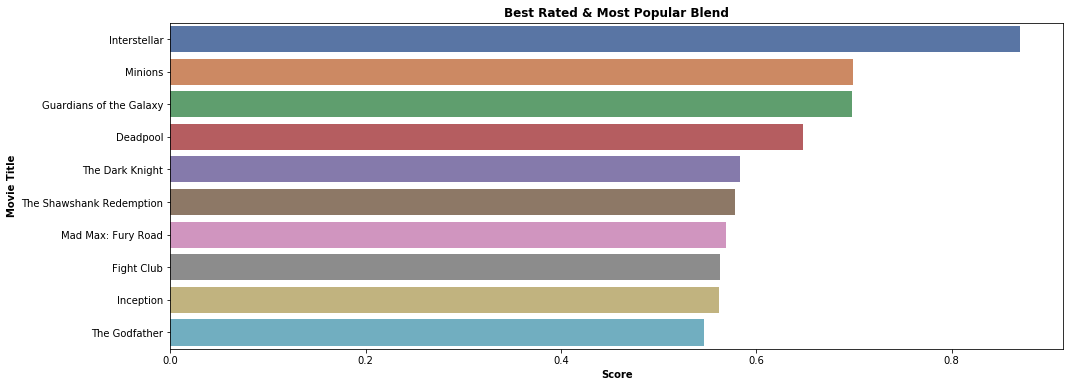

In [13]:
scored = movies_clean.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored['score'].head(10), y=scored['original_title'].head(10), data=scored, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('scored_movies.png')


#Content-Based Filtering¶


###Word Vectorization and TF-IDF
TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using Abhishek Thakur's arguments for TF-IDF
tfv = TfidfVectorizer(stop_words='english')

# Filling NaNs with empty string
movies_clean['overview'] = movies_clean['overview'].fillna('')
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(movies_clean['overview'])

tfv_matrix.shape

(4803, 20978)

###Calculating Similarity Scores

In [15]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(movies_clean.index, index=movies_clean['original_title']).drop_duplicates()
indices

original_title
Avatar                                            0
Pirates of the Caribbean: At World's End          1
Spectre                                           2
The Dark Knight Rises                             3
John Carter                                       4
Spider-Man 3                                      5
Tangled                                           6
Avengers: Age of Ultron                           7
Harry Potter and the Half-Blood Prince            8
Batman v Superman: Dawn of Justice                9
Superman Returns                                 10
Quantum of Solace                                11
Pirates of the Caribbean: Dead Man's Chest       12
The Lone Ranger                                  13
Man of Steel                                     14
The Chronicles of Narnia: Prince Caspian         15
The Avengers                                     16
Pirates of the Caribbean: On Stranger Tides      17
Men in Black 3                                   

In [0]:
# Credit to Ibtesam Ahmed for the skeleton code
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]
    
    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))
    

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
   
    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]
   

    # Top 10 most similar movies
    return movies_clean['original_title'].iloc[movie_indices]

In [17]:
#Test
give_rec('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: original_title, dtype: object

In [18]:
give_rec("The Dark Knight Rises")

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: original_title, dtype: object

**"The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system. We need to use more metadata to increasing the quality of system.**

**We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.**

In [0]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies_clean[feature] = movies_clean[feature].apply(literal_eval)


In [0]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [0]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []


In [0]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies_clean['director'] = movies_clean['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies_clean[feature] = movies_clean[feature].apply(get_list)


In [33]:
movies_clean[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [0]:
movies_clean.head(3)



**The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.**


In [0]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [0]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies_clean[feature] = movies_clean[feature].apply(clean_data)


In [0]:
movies_clean.head(3)

In [0]:
#string contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies_clean['soup'] = movies_clean.apply(create_soup, axis=1)

In [0]:
movies_clean.head(3)

**The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.**

In [0]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_clean['soup'])


In [0]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(count_matrix, count_matrix)

In [0]:
#Reset index of our main DataFrame and construct reverse mapping as before
movies_clean = movies_clean.reset_index()
indices = pd.Series(movies_clean.index, index=movies_clean['original_title'])


In [49]:
give_rec("The Dark Knight Rises",sig)

65                     The Dark Knight
119                      Batman Begins
1196                      The Prestige
3073                 Romeo Is Bleeding
72                       Suicide Squad
82      Dawn of the Planet of the Apes
157             Exodus: Gods and Kings
210                     Batman & Robin
280                     Public Enemies
299                     Batman Forever
Name: original_title, dtype: object